In [ ]:
# default_exp data.validation

# Spliting data

> Functions required to perform cross-validation and transform unique time series sequence into multiple samples ready to be used by a time series model.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *

In [ ]:
#export
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#export
def check_overlap(a, b):
    a = toarray(a)
    b = toarray(b)
    overlap = np.isin(a, b)
    if isinstance(overlap[0], (list, L, np.ndarray, torch.Tensor)):  overlap = overlap[0] 
    if not any(overlap): return False
    else: return a[overlap]


def leakage_finder(*splits, verbose=True):
    '''You can pass splits as a tuple, or train, valid, ...'''
    splits = L(*splits)
    overlaps = 0
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            overlap = check_overlap(splits[i], splits[j])
            if overlap: 
                pv(f'overlap between splits [{i}, {j}] {overlap}', verbose)
                overlaps += 1
    assert overlaps == 0, 'Please, review your splits!'


def balance_idx(o, shuffle=False, random_state=None, verbose=False):
    if isinstance(o, list): o = L(o)
    idx_ = np.arange(len(o)).reshape(-1, 1)
    ros = RandomOverSampler(random_state=random_state)
    resampled_idxs, _ = ros.fit_resample(idx_, np.asarray(o))
    new_idx = L(resampled_idxs.reshape(-1,).tolist())
    if shuffle: new_idx = random_shuffle(new_idx)
    return new_idx

In [ ]:
a = np.arange(10)
b = np.arange(10, 20)
test_eq(check_overlap(a, b), False)
a = np.arange(10)
b = np.arange(9, 20)
test_eq(check_overlap(a, b), [9])

In [ ]:
l = L(list(concat(np.zeros(5), np.ones(10)).astype(int)))
balanced_idx = balance_idx(l)
test_eq(np.mean(l[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

l = list(concat(np.zeros(5), np.ones(10)).astype(int))
balanced_idx = balance_idx(l)
test_eq(np.mean(L(l)[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

a = concat(np.zeros(5), np.ones(10)).astype(int)
balanced_idx = balance_idx(a)
test_eq(np.mean(a[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

t = concat(torch.zeros(5), torch.ones(10))
balanced_idx = balance_idx(t, shuffle=True)
test_eq(t[balanced_idx].mean(), 0.5)
test_eq(isinstance(balanced_idx, L), True)

In [ ]:
a, b = np.arange(100_000), np.arange(100_000, 200_000)

In [ ]:
soft_labels = True
filter_pseudolabels = .5
balanced_pseudolabels = True


pseudolabels = torch.rand(1000, 3)
pseudolabels = torch.softmax(pseudolabels, -1) if soft_labels else torch.argmax(pseudolabels, -1)
hpl = torch.argmax(pseudolabels, -1) if soft_labels else pseudolabels

if filter_pseudolabels and pseudolabels.ndim > 1: 
    error = 1 - pseudolabels.max(-1).values
    filt_pl_idx = np.arange(len(error))[error < filter_pseudolabels]
    filt_pl = pseudolabels[error < filter_pseudolabels]
    assert len(filt_pl) > 0, 'no filtered pseudolabels'
    filt_hpl = torch.argmax(filt_pl, -1)
else: 
    filt_pl_idx = np.arange(len(pseudolabels))
    filt_pl = filt_hpl = pseudolabels
pl_split = filt_pl_idx[balance_idx(filt_hpl)] if balanced_pseudolabels else filt_pl_idx
test_eq(hpl[pl_split].float().mean(), np.mean(np.unique(hpl)))

In [ ]:
#export
def TrainValidTestSplitter(n_splits:int=1, valid_size:Union[float, int]=0.2, test_size:Union[float, int]=0., train_only:bool=False,
                           stratify:bool=True, balance:bool=False, shuffle:bool=True, random_state:Union[None, int]=None, verbose:bool=False, **kwargs):
    "Split `items` into random train, valid (and test optional) subsets."
    
    if not shuffle and stratify and not train_only: 
        pv('stratify set to False because shuffle=False. If you want to stratify set shuffle=True', verbose)
        stratify = False
        
    def _inner(o, **kwargs):
        if stratify:
            n_unique, unique_counts = np.unique(o, return_counts=True)
            if np.min(unique_counts) >= 2 and np.min(unique_counts) >= n_splits: stratify_ = stratify  
            elif np.min(unique_counts) < n_splits: 
                stratify_ = False
                pv(f'stratify set to False as n_splits={n_splits} cannot be greater than the min number of members in each class ({np.min(unique_counts)}).', 
                   verbose)
            else:
                stratify_ = False
                pv('stratify set to False as the least populated class in o has only 1 member, which is too few.', verbose)
        else: stratify_ = False
        vs = 0 if train_only else 1. / n_splits if n_splits > 1 else int(valid_size * len(o)) if isinstance(valid_size, float) else valid_size
        if test_size: 
            ts = int(test_size * len(o)) if isinstance(test_size, float) else test_size
            train_valid, test = train_test_split(range(len(o)), test_size=ts, stratify=o if stratify_ else None, shuffle=shuffle, 
                                                 random_state=random_state, **kwargs)
            test = toL(test)
            if shuffle: test = random_shuffle(test, random_state)
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o[train_valid])
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                test_ = L(L([test]) * n_splits) if n_splits > 1 else test
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_, test_)]
                else: 
                    return train_, valid_, test_
            elif n_splits > 1: 
                if stratify_: 
                    splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)), o[train_valid])
                else:
                    splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    train_.append(L(L(train_valid)[train]))
                    valid_.append(L(L(train_valid)[valid]))
                test_ = L(L([test]) * n_splits)
                return [split for split in itemify(train_, valid_, test_)]
            else:
                train, valid = train_test_split(range(len(train_valid)), test_size=vs, random_state=random_state, 
                                                stratify=o[train_valid] if stratify_ else None, shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: 
                    train = random_shuffle(train, random_state)
                    valid = random_shuffle(valid, random_state)
                return (L(L(train_valid)[train]), L(L(train_valid)[valid]),  test)
        else: 
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o)
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_)]
                else: 
                    return (train_, valid_)
            elif n_splits > 1: 
                if stratify_: splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)), o)
                else: splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    if not isinstance(train, (list, L)):  train = train.tolist()
                    if not isinstance(valid, (list, L)):  valid = valid.tolist()
                    train_.append(L(train))
                    valid_.append(L(L(valid)))
                return [split for split in itemify(train_, valid_)]
            else:
                train, valid = train_test_split(range(len(o)), test_size=vs, random_state=random_state, stratify=o if stratify_ else None, 
                                                shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                return train, valid
    return _inner

In [ ]:
#export
def get_splits(o, n_splits:int=1, valid_size:float=0.2, test_size:float=0., train_only:bool=False, train_perc:float=1., balance:bool=False,
               shuffle:bool=True, stratify:bool=True, check_splits:bool=True, random_state:Union[None, int]=None, verbose:bool=False):
    '''Arguments: 
        o            : object to which splits will be applied, usually target.
        n_splits     : number of folds. Must be an int >= 1.
        valid_size   : size of validation set. Only used if n_splits = 1. If n_splits > 1 valid_size = (1. - test_size) / n_splits. 
        test_size    : size of test set. Default = 0.
        train_only   : if True valid set == train set. This may be useful for debugging purposes.
        train_perc   : percentage of the train set used. Default = 1. Useful for to get learning curves with different train sizes.
        balance      : whether to balance data so that train always contain the same number of items per class.
        shuffle      : whether to shuffle data before splitting into batches. Note that the samples within each split will be shuffle.
        stratify     : whether to create folds preserving the percentage of samples for each class.
        check_splits : whether to perform leakage and completion checks.
        random_state : when shuffle is True, random_state affects the ordering of the indices. Pass an int for reproducible output.
    '''
    if n_splits == 1 and valid_size == 0. and  test_size == 0.: train_only = True
    if balance: stratify = True
    splits = TrainValidTestSplitter(n_splits, valid_size=valid_size, test_size=test_size, train_only=train_only, stratify=stratify, 
                                      balance=balance, shuffle=shuffle, random_state=random_state, verbose=verbose)(o)
    if check_splits:
        if train_only or (n_splits == 1 and valid_size == 0): print('valid == train')
        elif n_splits > 1: 
            for i in range(n_splits): 
                leakage_finder([*splits[i]], verbose=True)
                cum_len = 0
                for split in splits[i]: cum_len += len(split)
                if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
        else: 
            leakage_finder([splits], verbose=True)
            cum_len = 0
            if not isinstance(splits[0], Integral):
                for split in splits: cum_len += len(split)
            else: cum_len += len(splits)
            if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
    if train_perc and train_perc > 0 and train_perc < 1: 
        if n_splits > 1:
            splits = list(splits)
            for i in range(n_splits): 
                splits[i] = list(splits[i])
                splits[i][0] = L(np.random.choice(splits[i][0], int(len(splits[i][0]) * train_perc), False).tolist())
                if train_only:
                    if valid_size != 0: splits[i][1] = splits[i][0]
                    if test_size != 0: splits[i][2] = splits[i][0]
                splits[i] = tuple(splits[i])
            splits = tuple(splits)
        else: 
            splits = list(splits)
            splits[0] = L(np.random.choice(splits[0], int(len(splits[0]) * train_perc), False).tolist())
            if train_only:
                if valid_size != 0: splits[1] = splits[0]
                if test_size != 0: splits[2] = splits[0]
            splits = tuple(splits)
    return splits

In [ ]:
n_splits                = 1

cv                      = True
valid_size              = 0.2
test_size               = 0.2
train_only              = False  # set to True for debugging (valid = train)
train_perc              = 1.
stratify                = True
balance                 = True
shuffle                 = True
predefined_splits       = None


check_splits = True
random_state = 23

y = np.random.randint(0, 3, 1000) + 100

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_perc=train_perc, check_splits=check_splits, random_state=random_state, verbose=True)
splits

((#618) [278,480,263,939,348,764,269,84,207,669...],
 (#200) [399,362,748,724,614,526,282,694,584,907...],
 (#200) [236,567,486,582,123,491,309,291,95,285...])

In [ ]:
#export
def TimeSplitter(valid_pct=0.2):
    "Create function that splits `items` between train/val with `valid_pct` without shuffling data."
    def _inner(o):
        cut = int(valid_pct * len(o))
        idx = np.arange(len(o))
        return L(idx[:-cut].tolist()), L(idx[-cut:].tolist())
    return _inner

In [ ]:
y = np.arange(1000) + 100
test_eq(TimeSplitter(valid_pct=0.2)(y)[1], L(np.arange(800, 1000).tolist()))
TimeSplitter(valid_pct=0.2)(y)

((#800) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

In [ ]:
n_splits                = 5

cv                      = True
valid_size              = 0.2  
test_size               = 0
train_only              = False  # set to True for debugging (valid = train)
train_perc              = 1.
stratify                = True
balance                 = True
shuffle                 = True
predefined_splits       = None


check_splits = True
random_state = 23

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_perc=train_perc, check_splits=check_splits, random_state=random_state, verbose=True)
split = splits[0] if n_splits == 1 else splits[0][0]
y[split].mean(), split

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).


(601.11, (#800) [314,194,782,789,502,917,137,415,904,181...])

In [ ]:
list([splits[0], splits[1], splits[2], splits[3], splits[4]])

[((#800) [314,194,782,789,502,917,137,415,904,181...],
  (#200) [362,151,934,378,95,597,500,117,980,844...]),
 ((#800) [312,198,777,788,515,910,145,413,898,186...],
  (#200) [352,133,955,396,64,596,442,79,991,882...]),
 ((#800) [311,197,783,791,507,922,145,416,908,184...],
  (#200) [338,125,912,361,54,594,486,88,994,859...]),
 ((#800) [296,181,782,789,493,917,130,401,905,165...],
  (#200) [405,199,953,444,113,610,515,137,997,881...]),
 ((#800) [320,190,782,788,506,906,141,412,893,178...],
  (#200) [336,149,942,358,49,582,472,70,990,907...])]

In [ ]:
n_splits = 5
valid_size = 0.
test_size = 0.
shuffle = True
stratify = True
train_only = True
train_perc = 1.
check_splits = True
random_state = 1

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, stratify=stratify,
                    train_only=train_only, train_perc=train_perc, check_splits=check_splits, random_state=random_state, verbose=True)
for split in splits: 
    test_eq(len(split[0]), len(y))
    test_eq(np.sort(split[0]), np.arange(len(y)))

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).
valid == train


In [ ]:
n_splits = 5
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, shuffle=False, check_splits=True)
test_eq(np.concatenate((L(zip(*splits))[1])), np.arange(len(y)))

splits = get_splits(y, n_splits=n_splits, shuffle=True, check_splits=True)
test_eq(np.sort(np.concatenate((L(zip(*splits))[1]))), np.arange(len(y)))

In [ ]:
n_splits = 2
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, test_size=0.2, shuffle=False)
for i in range(n_splits): leakage_finder(*splits[i])
test_eq(len(splits), n_splits)
test_eq(len(splits[0]), 3)
s = []
[s.extend(split) for split in splits[0]]
test_eq(np.sort(s), np.arange(len(y)))
s = []
[s.extend(split) for split in splits[1]]
test_eq(np.sort(s), np.arange(len(y)))

In [ ]:
y = np.random.randint(0, 2, 1000)
splits1 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits2 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits3 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
splits4 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
test_eq(splits1[0], splits2[0])
test_ne(splits3[0], splits4[0])

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
test_eq(len(splits), 2)

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True)
test_eq(len(splits), 2)

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=20, random_state=23, stratify=True)
test_eq(len(splits), 3)
leakage_finder(*splits)

In [ ]:
splits = TrainValidTestSplitter(valid_size=.25, test_size=20, random_state=23, stratify=True)(np.random.randint(0, 2, 100))
test_eq(len(splits[1]), 25)
test_eq(len(splits[2]), 20)

In [ ]:
o = np.random.randint(0, 2, 1000)
for p in [1, .75, .5, .25, .125]:
    splits = get_splits(o, train_perc=p)
    test_eq(len(splits[0]), len(o) * .8 * p)

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, valid_size=.2, test_size=.2)
test_eq(np.mean(y[splits[0]])==np.mean(y[splits[1]])==np.mean(y[splits[2]]), True)
splits

((#60) [58,42,57,94,82,39,18,83,93,44...],
 (#20) [45,29,43,85,24,74,91,64,69,87...],
 (#20) [36,88,72,15,5,31,86,63,95,51...])

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, n_splits=1, valid_size=.2, test_size=.2, shuffle=False)
# test_eq(splits[0] + splits[1] + splits[2], np.arange(100))
splits

((#60) [0,1,2,3,4,5,6,7,8,9...],
 (#20) [60,61,62,63,64,65,66,67,68,69...],
 (#20) [80,81,82,83,84,85,86,87,88,89...])

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17)
test_eq(len(splits[1]), 21)
test_eq(len(splits[2]), 17)

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17, train_perc=.2)
splits

((#12) [49,52,26,59,92,95,57,0,10,44...],
 (#21) [12,41,36,97,35,69,85,82,45,67...],
 (#17) [18,70,17,63,1,39,86,40,37,3...])

In [ ]:
#export
def get_predefined_splits(*xs):
    '''xs is a list with X_train, X_valid, ...'''
    splits_ = []
    start = 0
    for x in xs: 
        splits_.append(L(list(np.arange(start, start + len(x)))))
        start += len(x)
    return tuple(splits_)

def combine_split_data(xs, ys=None):
    '''xs is a list with X_train, X_valid, .... ys is None or a list with y_train, y_valid, .... '''
    xs = [to3d(x) for x in xs]
    splits = get_predefined_splits(*xs)
    if ys is None: return concat(*xs), None, splits
    else: return concat(*xs), concat(*ys), splits

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,3,4), np.random.randint(0,2,3), np.random.rand(2,3,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train, X[splits[0]])
test_eq(X_valid, X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,4), np.random.randint(0,2,3), np.random.rand(2,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train[:, None], X[splits[0]])
test_eq(X_valid[:, None], X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the columns where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.iloc[:, data_cols].values
    _, seq_len = data.shape
    X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    return X, y

In [ ]:
#export
def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
    if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
    get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
    get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
    if horizon == 0 and get_x is not None and get_y is not None:
        assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
        'you need to change either horizon, get_x or get_y to avoid leakage'
    wl = window_length
    ws = wl if stride is None else stride
    start = start if start is not None else np.random.choice(ws, 1)[0]
    def _inner(o):
        if isinstance(o, pd.DataFrame): 
            columns = o.columns.values if seq_first else o.T.columns.values
            o = o.values
            if o.ndim > 1: 
                if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
                elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
                else: _get_x = slice(None)
                _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
        elif o.ndim > 1: 
            _get_x = ifnone(get_x, slice(None))
            _get_y = ifnone(get_y, slice(None))
        if seq_first: o = o.T
        o = o.squeeze()
        _seq_len = o.shape[-1]
        assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
        x, y = [], []
        for i in range(start, _seq_len - wl - horizon + 1, ws):
            if o.ndim == 1: 
                x.append(o[..., slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
            else: 
                x.append(o[..., _get_x, slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
        X = to3d(stack(x))
        if X.dtype == 'O': X = X.astype(np.float32)
        y = stack(y).squeeze() if y != [] else None
        return X, y
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#6) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),),(array([[5, 6, 7, 8, 9]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, start=None)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[2, 3, 4, 5, 6]]), 7), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[12, 13, 14, 15, 16]]), 17)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


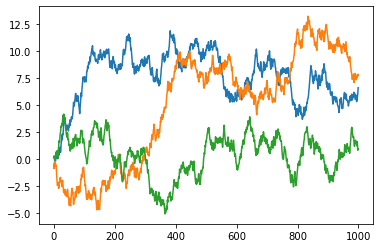

[(array([[ 0.21183125,  0.29239741,  0.11115675, -0.26223723, -0.50588717],
       [-0.45956447, -0.86143855, -0.37883857, -0.19262919, -0.31040955]]), 0.05758922696803537), (array([[-0.16350555, -0.13242096,  0.27261466,  0.59607605,  0.13470857],
       [-0.22049756, -0.63840328, -0.54528035, -0.80376825, -1.28112254]]), 0.5290752631864282), (array([[ 0.32756576,  0.09655667,  0.30205225,  0.06952683,  0.49131272],
       [-1.73946238, -2.1513822 , -2.42498733, -2.24350408, -2.13584602]]), 0.386892977745942), (array([[ 0.77948248,  0.49570681,  0.37451131,  0.494644  ,  0.81834529],
       [-2.28837529, -2.69255527, -2.5839428 , -2.19387208, -2.15472229]]), 1.571175955276224), (array([[ 0.9417457 ,  1.11304268,  0.63246682,  0.91159347,  1.40097592],
       [-1.75373842, -1.90279057, -1.6778187 , -2.05105584, -1.96647997]]), 3.0515342225161852), (array([[ 1.66340214,  1.78968577,  2.25649444,  1.81214069,  2.3058997 ],
       [-2.2050158 , -2.19407451, -2.52470902, -2.06558984, -1.94

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,-0.415494,-0.169298,0.005592
1,-0.292530,0.103097,-0.263776
2,-0.584551,0.356873,0.221655
3,-1.011972,0.393258,0.230043
4,-1.191245,0.637369,0.645884
...,...,...,...
95,-1.733829,1.718290,-5.466661
96,-2.046564,1.372043,-5.748374
97,-1.886158,1.040182,-5.740592
98,-2.121290,1.100050,-5.758725


[(array([[-0.41549403, -0.29252956, -0.58455061, -1.01197246, -1.19124451],
       [-0.16929815,  0.10309745,  0.35687294,  0.39325826,  0.6373694 ]]), 0.6458839171827142), (array([[-0.29252956, -0.58455061, -1.01197246, -1.19124451, -0.82653817],
       [ 0.10309745,  0.35687294,  0.39325826,  0.6373694 ,  0.71592269]]), 0.32301763326570254), (array([[-0.58455061, -1.01197246, -1.19124451, -0.82653817, -0.93775706],
       [ 0.35687294,  0.39325826,  0.6373694 ,  0.71592269,  1.10098201]]), 0.14735000841860812), (array([[-1.01197246, -1.19124451, -0.82653817, -0.93775706, -1.42137373],
       [ 0.39325826,  0.6373694 ,  0.71592269,  1.10098201,  1.13571243]]), 0.4357618782773548), (array([[-1.19124451, -0.82653817, -0.93775706, -1.42137373, -1.79227258],
       [ 0.6373694 ,  0.71592269,  1.10098201,  1.13571243,  1.05535689]]), 0.698912336212515), (array([[-0.82653817, -0.93775706, -1.42137373, -1.79227258, -2.09434089],
       [ 0.71592269,  1.10098201,  1.13571243,  1.05535689,  1.

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.389642,0.020541,0.358574,0.049078,-0.016711
1,-0.673545,0.216544,0.632219,0.123473,0.034894
2,-0.488736,-0.265632,1.022966,0.486180,0.003074
3,-0.211416,-0.545522,0.572016,0.979930,0.029968
4,0.076784,-1.011656,0.285186,0.784082,0.210961
...,...,...,...,...,...
95,2.773723,-1.975036,-4.573746,-2.752977,3.443718
96,2.573289,-2.318904,-4.436604,-3.083126,3.891024
97,2.645264,-2.774773,-4.505512,-2.833544,4.269601
98,2.953188,-3.144531,-4.728736,-2.461954,4.012456


[(array([[-0.38964224, -0.67354535, -0.48873647, -0.21141616,  0.07678386],
       [ 0.02054135,  0.21654373, -0.26563156, -0.54552176, -1.01165632],
       [ 0.3585743 ,  0.63221904,  1.02296615,  0.57201647,  0.28518632],
       [ 0.04907794,  0.1234728 ,  0.48618012,  0.97992966,  0.78408175]]), 0.21096143924994992), (array([[-0.67354535, -0.48873647, -0.21141616,  0.07678386, -0.01133176],
       [ 0.21654373, -0.26563156, -0.54552176, -1.01165632, -1.36629364],
       [ 0.63221904,  1.02296615,  0.57201647,  0.28518632, -0.01743263],
       [ 0.1234728 ,  0.48618012,  0.97992966,  0.78408175,  1.11425221]]), 0.4159557396870661), (array([[-0.48873647, -0.21141616,  0.07678386, -0.01133176, -0.19896196],
       [-0.26563156, -0.54552176, -1.01165632, -1.36629364, -1.17418384],
       [ 1.02296615,  0.57201647,  0.28518632, -0.01743263, -0.32715166],
       [ 0.48618012,  0.97992966,  0.78408175,  1.11425221,  0.80465246]]), -0.031266669315896944), (array([[-0.21141616,  0.07678386, 

       [-2.75297709, -3.08312586, -2.83354398, -2.46195378, -2.91190448]]), 4.257108156178531)]


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.499315,-0.765527,-0.666795,-0.667909,-0.828310,-1.103347,-0.901587,-0.941066,-0.649885,-0.801118,...,-0.100586,-0.407630,0.075326,0.220536,0.135375,-0.075922,-0.108642,-0.120284,-0.282263,-0.707612
var_1,-0.149619,-0.034620,0.242545,-0.062621,0.075681,0.394688,-0.049783,-0.211773,-0.057920,0.237274,...,2.276807,2.640665,2.328583,2.151248,2.353203,1.857341,1.598867,1.196342,1.483740,1.844850
var_2,-0.119137,-0.043466,-0.209750,0.231864,-0.133649,-0.154142,-0.234171,0.249110,0.451879,0.537708,...,-0.436006,-0.694947,-0.513595,-0.839996,-0.807583,-1.052775,-0.887889,-1.253863,-1.083766,-0.669201
var_3,0.484148,0.666775,0.581875,0.778413,1.163395,1.027285,1.408437,1.285444,1.468274,1.626151,...,7.322229,7.014449,7.289765,7.079266,7.060620,6.849162,7.104078,6.699596,6.544869,6.547317
target,-0.367462,-0.210210,-0.278317,-0.740577,-0.308368,-0.427027,-0.691610,-0.786374,-1.258375,-0.829273,...,0.763042,1.040997,1.250299,0.886344,1.089340,1.285743,1.294655,0.990149,0.570819,0.487083


[(array([[-0.49931504, -0.76552677, -0.66679501, -0.66790895, -0.82831021],
       [-0.14961877, -0.03461982,  0.24254535, -0.06262052,  0.07568092],
       [-0.11913677, -0.043466  , -0.2097502 ,  0.23186355, -0.13364946],
       [ 0.484148  ,  0.66677493,  0.58187517,  0.77841277,  1.16339486]]), -0.3083684230922069), (array([[-0.76552677, -0.66679501, -0.66790895, -0.82831021, -1.10334728],
       [-0.03461982,  0.24254535, -0.06262052,  0.07568092,  0.3946877 ],
       [-0.043466  , -0.2097502 ,  0.23186355, -0.13364946, -0.15414224],
       [ 0.66677493,  0.58187517,  0.77841277,  1.16339486,  1.02728481]]), -0.4270272582714061), (array([[-0.66679501, -0.66790895, -0.82831021, -1.10334728, -0.90158682],
       [ 0.24254535, -0.06262052,  0.07568092,  0.3946877 , -0.04978297],
       [-0.2097502 ,  0.23186355, -0.13364946, -0.15414224, -0.23417131],
       [ 0.58187517,  0.77841277,  1.16339486,  1.02728481,  1.40843682]]), -0.6916097942361288), (array([[-0.66790895, -0.82831021, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.362801,0.060122,0.180323,0.453362,-0.018593,0.104734,-0.226023,-0.000415,-0.414685,-0.698956,...,-0.193525,0.163746,0.442455,0.365871,0.490944,0.710834,0.929992,1.256778,1.645923,1.855838
var_1,0.295376,0.148083,0.038752,0.133535,0.255869,0.731325,0.720932,1.097422,1.171978,0.856630,...,4.293415,3.829964,3.664307,3.625063,3.847703,4.345274,4.005860,3.794908,4.153389,3.695954
var_2,0.483937,-0.002506,-0.110414,-0.469144,-0.697345,-0.484661,-0.269223,-0.240442,0.259111,-0.115515,...,-3.784776,-3.791515,-4.289678,-4.766718,-4.335426,-4.498539,-4.790974,-5.004377,-4.842113,-5.124750
var_3,-0.431327,-0.421229,-0.568844,-0.732844,-0.509973,-0.952216,-1.359993,-1.717447,-2.161343,-2.381607,...,-5.318499,-5.043268,-5.115443,-5.168755,-4.812587,-4.337578,-4.365284,-4.223008,-4.336107,-4.735953
target,0.276291,0.775536,0.629929,0.402674,0.521240,0.337736,0.002164,0.210699,-0.222886,-0.449147,...,-1.318493,-1.696650,-1.738814,-2.060383,-1.628284,-1.727340,-1.460252,-0.996182,-1.005215,-1.100855


[(array([[ 0.36280109,  0.06012161,  0.18032336,  0.45336163, -0.01859324],
       [ 0.29537581,  0.1480831 ,  0.03875225,  0.13353481,  0.25586928],
       [ 0.48393675, -0.00250612, -0.11041381, -0.46914447, -0.69734512],
       [-0.43132729, -0.42122923, -0.56884398, -0.73284356, -0.50997265]]), 0.5212402809401845), (array([[ 1.04733609e-01, -2.26023062e-01, -4.14619876e-04,
        -4.14684972e-01, -6.98956076e-01],
       [ 7.31324874e-01,  7.20931851e-01,  1.09742153e+00,
         1.17197824e+00,  8.56629606e-01],
       [-4.84660897e-01, -2.69223047e-01, -2.40442315e-01,
         2.59111001e-01, -1.15515411e-01],
       [-9.52215609e-01, -1.35999299e+00, -1.71744693e+00,
        -2.16134271e+00, -2.38160736e+00]]), -0.44914748058297593), (array([[-0.39074557, -0.77285857, -0.84035949, -0.57910905, -0.69210987],
       [ 0.57177738,  0.36710862,  0.0469154 , -0.20303764, -0.45842034],
       [ 0.32222651, -0.11958095, -0.50729721, -1.00272408, -1.04081027],
       [-2.60124899, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.490066,-0.016230,0.470295,0.451925,-0.051982
1,0.536516,0.291256,0.573321,0.324797,-0.229661
2,0.128704,-0.062198,0.376044,0.356397,-0.031826
3,0.011204,-0.185376,0.235996,0.196691,0.339379
4,-0.074760,-0.410759,-0.140125,0.475071,0.816095
...,...,...,...,...,...
95,5.169752,3.669338,-3.486630,-0.215086,-5.124599
96,4.933104,3.437601,-3.266354,-0.368001,-5.206997
97,4.836974,3.792029,-3.300690,-0.060769,-5.420029
98,4.829426,3.995764,-3.039909,-0.371211,-5.628226


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipy